# active inference model of agency task (basic)

### prerequisites

In [1]:
# !pip install inferactively-pymdp
import os
import sys
import pathlib
import numpy as np 
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import pymdp

from pymdp import utils 
from pymdp import maths
from pymdp.maths import softmax
from pymdp.agent import Agent

### specifying the states and observations

In [2]:
context_names = ['agt1_positive', 'agt1_negative', 
                 'agt2_positive', 'agt2_negative', 'zero']
choice_agt1_names = ['Press_agt1', 'noPress_agt1']
choice_agt2_names = ['Press_agt2', 'noPress_agt2']

""" Define `num_states` and `num_factors` below """
num_states = [len(context_names), len(choice_agt1_names), len(choice_agt2_names)]
num_factors = len(num_states)

context_action_names = ['do_nothing']
choice_action_agt1_names = ['Action_agt1', 'noAction_agt1']
choice_action_agt2_names = ['Action_agt2', 'noAction_agt2']

""" Define `num_controls` below """
num_controls = [len(context_action_names), len(choice_action_agt1_names), len(choice_action_agt2_names)]

outcome_obs_names = ['outcome_present', 'outcome_absent']
choice_obs_agt1_names = ['Press_agt1', 'noPress_agt1']
choice_obs_agt2_names = ['Press_agt2', 'noPress_agt2']

""" Define `num_obs` and `num_modalities` below """
num_obs = [len(outcome_obs_names), len(choice_obs_agt1_names), len(choice_obs_agt2_names)]
num_modalities = len(num_obs)

In [3]:
def create_A(p_outcome=1.0):
    
    A = utils.initialize_empty_A(num_obs, num_states)
    
    '''likelihood matrix for outcome modality'''
    
    p_outcome = 1.0 # probability of outcome occurring, according to the agent's generative model
    
    A_outcome = np.zeros( (len(outcome_obs_names), len(context_names), len(choice_agt1_names), len(choice_agt2_names)) )
    
    # P(observation|Press_agt1, Press_agt2)
    A_outcome[:,:,0,0] = [[p_outcome, 1.0 - p_outcome, p_outcome, 1.0 - p_outcome, .5], 
                          [1.0 - p_outcome, p_outcome, 1.0 - p_outcome, p_outcome, .5]]
    
    # P(observation|Press_agt1, noPress_agt2)
    A_outcome[:,:,0,1] = [[p_outcome, 1.0 - p_outcome, 1.0 - p_outcome, p_outcome, .5],
                          [1.0 - p_outcome, p_outcome, p_outcome, 1.0 - p_outcome, .5]]
    
    # P(observation|noPress_agt1, Press_agt2)
    A_outcome[:,:,1,0] = [[1.0 - p_outcome, p_outcome, p_outcome, 1.0 - p_outcome, .5],
                          [p_outcome, 1.0 - p_outcome, 1.0 - p_outcome, p_outcome, .5]]
    
    # P(observation|noPress_agt1, noPress_agt2)
    A_outcome[:,:,1,1] = [[1.0 - p_outcome, p_outcome, 1.0 - p_outcome, p_outcome, .5],
                          [p_outcome, 1.0 - p_outcome, p_outcome, 1.0 - p_outcome, .5]]
    
    
    '''likelihood matrix for agent 1's proprioception modality'''        
    A_choice_agt1 = np.zeros((len(choice_obs_agt1_names), len(context_names), len(choice_agt1_names), len(choice_agt2_names)))
    
    # P(observation|Press_agt1, Press_agt2)
    A_choice_agt1[0,:,0,0] = 1.0
    
    # P(observation|Press_agt1, noPress_agt2)
    A_choice_agt1[0,:,0,1] = 1.0
    
    # P(observation|noPress_agt1, Press_agt2)
    A_choice_agt1[1,:,1,0] = 1.0
    
    # P(observation|noPress_agt1, noPress_agt2)
    A_choice_agt1[1,:,1,1] = 1.0

    
    '''likelihood matrix for agent 2's proprioception modality'''        
    A_choice_agt2 = np.zeros((len(choice_obs_agt2_names), len(context_names), len(choice_agt1_names), len(choice_agt2_names)))
    
    # P(observation|Press_agt1, Press_agt2)
    A_choice_agt2[0,:,0,0] = 1.0
    
    # P(observation|Press_agt1, noPress_agt2)
    A_choice_agt2[1,:,0,1] = 1.0
    
    # P(observation|noPress_agt1, Press_agt2)
    A_choice_agt2[0,:,1,0] = 1.0
    
    # P(observation|noPress_agt1, noPress_agt2)
    A_choice_agt2[1,:,1,1] = 1.0
        
    A[0], A[1], A[2] = A_outcome, A_choice_agt1, A_choice_agt2
    
    return A

# A = create_A(p_outcome = 1.0)
# utils.plot_likelihood(A[0][:,:,0,0], title = "Probability of outcome, given nothing")
# utils.plot_likelihood(A[1][:,:,1,2], title = "Probability of outcome, given humanAction_compAction")
# utils.plot_likelihood(A[0][:,:,2], title = "Probability of outcome, given humanAction_compNoAction")
# utils.plot_likelihood(A[0][:,:,3], title = "Probability of outcome, given humanNoAction_compAction")
# utils.plot_likelihood(A[0][:,:,4], title = "Probability of outcome, given humanNoAction_compNoAction")
# utils.plot_likelihood(A[1][:,0,:], title="Mapping between sensed states and true states for Actions")

In [4]:
def create_B(p_change = 0.0):
    # `p_change`: probability of the context changing
    B = utils.initialize_empty_B(num_states, num_states)
    
    B_context = np.zeros( (len(context_names), len(context_names), len(context_action_names)) )
    B_context[:,:,0] = np.eye(len(context_names))
    
    B_choice_agt1 = np.zeros( (len(choice_agt1_names), len(choice_agt1_names), len(choice_action_agt1_names)) )
    
    for choice_i in range(len(choice_agt1_names)):
        B_choice_agt1[choice_i, :, choice_i] = 1.0
    
    B_choice_agt2 = np.zeros( (len(choice_agt2_names), len(choice_agt2_names), len(choice_action_agt2_names)) )
    
    for choice_i in range(len(choice_agt2_names)):
        B_choice_agt2[choice_i, :, choice_i] = 1.0
        
    B[0], B[1], B[2] = B_context, B_choice_agt1, B_choice_agt2
    
    return B

# B = create_B(p_change=0.0)

# print(B[2][:,:,0])

In [5]:
def create_C(reward = 1.0, pun = 0.0, actioncost = 0.0):
    
    # define reward and punishment values mapping onto outcome_present and outcome_absent preferences
    
    C = utils.obj_array_zeros(num_obs)
    C[0] = np.array([reward, pun])
    C[1] = np.array([actioncost, 0.0])
    C[2] = np.array([0.0, 0.0])
    
    return C

# C = create_C(reward = 1.0, pun = 0.0)
# utils.plot_beliefs(softmax(C[0]), title = "Prior preferences for outcome_present and outcome_absent")

In [6]:
def create_D(p_context=1/float(num_states[0])):
    
    D = utils.obj_array(num_factors)
    
    D_context = np.ones(num_states[0])/float(num_states[0])
    
    D_choice_agt1 = np.array([0.5,0.5])
    
    D_choice_agt2 = np.array([0.5,0.5])

    D[0], D[1], D[2] = D_context, D_choice_agt1, D_choice_agt2
    
    return D

# D = create_D(p_context=1/float(num_states[0]))
# utils.plot_beliefs(softmax(D[1]), title = "Prior beliefs about probability of the contexts")

In [7]:
class AgencyTask(object):
    
    def __init__(self, context = None, p_action_agt2 = 0.5, p_outcome = 1.0):
        
        self.context_names = ['agt1_positive', 'agt1_negative',
                              'agt2_positive', 'agt2_negative', 'zero']
        if context == None:
            self.context = self.context_names[utils.sample(np.ones(num_states[0])/float(num_states[0]))] # randomly sample which context is selected
        else:
            self.context = context
            
        self.p_outcome = p_outcome
        self.p_action_agt2 = p_action_agt2
        
        self.outcome_obs_names = ['outcome_present', 'outcome_absent']
        
        
    def step(self, action):
        
        self.action_agt2_names = ['Action_agt2', 'noAction_agt2']
        self.action_agt2 = self.action_agt2_names[utils.sample(np.array([self.p_action_agt2, 1.0-self.p_action_agt2]))]
        
        if action == "Action_agt1" and self.action_agt2 == "Action_agt2":
            observed_choice_agt1 = "Press_agt1"
            observed_choice_agt2 = "Press_agt2"
            
            if self.context == "agt1_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.context == "agt1_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.context == "agt2_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.context == "agt2_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.context == "zero":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([0.5, 0.5]))]
                
        elif action == "Action_agt1" and self.action_agt2 == "noAction_agt2":
            observed_choice_agt1 = "Press_agt1"
            observed_choice_agt2 = "noPress_agt2"
            
            if self.context == "agt1_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.context == "agt1_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.context == "agt2_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.context == "agt2_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.context == "zero":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([0.5, 0.5]))]
                
        elif action == "noAction_agt1" and self.action_agt2 == "Action_agt2":
            observed_choice_agt1 = "noPress_agt1"
            observed_choice_agt2 = "Press_agt2"
            
            if self.context == "agt1_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.context == "agt1_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.context == "agt2_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.context == "agt2_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.context == "zero":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([0.5, 0.5]))]
                
        elif action == "noAction_agt1" and self.action_agt2 == "noAction_agt2":
            observed_choice_agt1 = "noPress_agt1"
            observed_choice_agt2 = "noPress_agt2"
            
            if self.context == "agt1_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.context == "agt1_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.context == "agt2_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.context == "agt2_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.context == "zero":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([0.5, 0.5]))]

        obs = [observed_outcome, observed_choice_agt1, observed_choice_agt2]

        return obs

In [8]:
def run_active_inference_loop(my_agent, my_env, T = 5, verbose = False):
    
    """ Initialize the first observation """
    obs_label = ["outcome_present", "Press_agt1", "Press_agt2"]  
    obs = [outcome_obs_names.index(obs_label[0]), choice_obs_agt1_names.index(obs_label[1]), choice_obs_agt2_names.index(obs_label[2])]
    
    first_choice = choice_obs_agt1_names.index(obs_label[1])
    choice_hist = np.zeros((2,T+1))
    choice_hist[first_choice,0] = 1.0
    
    belief_hist = np.zeros((5, T))
    belief_action_agt1_hist = np.zeros((2, T))
    belief_action_agt2_hist = np.zeros((2, T))
    context_hist = np.zeros(T)
    
    for t in range(T):
        context_hist[t] = env.context_names.index(env.context)
        qs = my_agent.infer_states(obs)
        
        belief_hist[:,t] = qs[0]
        belief_action_agt1_hist[:,t] = qs[1]
        belief_action_agt2_hist[:,t] = qs[2]
        
        if verbose:
             utils.plot_beliefs(qs[0], title = f"Beliefs about the context at time {t}")
#             utils.plot_beliefs(qs[1], title = f"Beliefs about the action_agt1 at time {t}")
#             utils.plot_beliefs(qs[2], title = f"Beliefs about the action_agt2 at time {t}")
            
        q_pi, efe = my_agent.infer_policies()
        chosen_action_id = my_agent.sample_action()
        
        movement_id = int(chosen_action_id[1])
        choice_hist[movement_id,t+1]= 1.0
        
        choice_action = choice_action_agt1_names[movement_id]
        
        obs_label = my_env.step(choice_action)
        
        obs = [outcome_obs_names.index(obs_label[0]), choice_obs_agt1_names.index(obs_label[1]), choice_obs_agt2_names.index(obs_label[2])]
        
        if verbose:
            print(f'Action at time {t}: {choice_action}')
            print(f'Outcome at time {t}: {obs_label[0]}')
            print(f'Obs_action_self at time {t}: {obs_label[1]}')
            print(f'Obs_action_other at time {t}: {obs_label[2]}')

    return choice_hist, belief_hist, context_hist

In [9]:
def plot_choices_beliefs(choice_hist, belief_hist, context_hist, pad_val=5.0):
    T = choice_hist.shape[1]
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15,13))
    
    axes[0].imshow(choice_hist[:,:-1], cmap = 'gray') 
    axes[0].set_xlabel('Timesteps')
    axes[0].set_yticks(ticks = range(2))
    axes[0].set_yticklabels(labels = choice_action_agt1_names)
    axes[0].set_title('Choices over time')
    
    axes[1].imshow(belief_hist, cmap = 'gray')
    axes[1].set_xlabel('Timesteps')
    axes[1].set_yticks(ticks = range(5))
    axes[1].set_yticklabels(labels = context_names)
    axes[1].set_title('Beliefs over time')
    axes[1].scatter(np.arange(T-1), context_hist, c = 'r', s = 50)
    
    fig.tight_layout(pad=pad_val)
    plt.show()

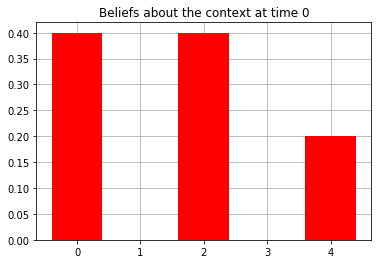

Action at time 0: Action_agt1
Outcome at time 0: outcome_absent
Obs_action_self at time 0: Press_agt1
Obs_action_other at time 0: noPress_agt2


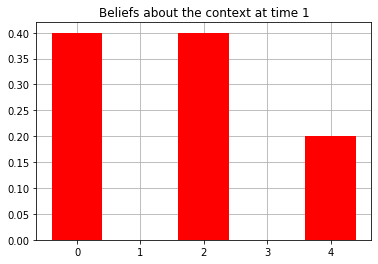

Action at time 1: Action_agt1
Outcome at time 1: outcome_absent
Obs_action_self at time 1: Press_agt1
Obs_action_other at time 1: Press_agt2


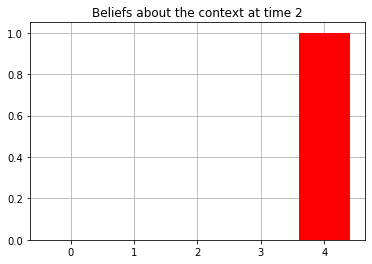

Action at time 2: noAction_agt1
Outcome at time 2: outcome_present
Obs_action_self at time 2: noPress_agt1
Obs_action_other at time 2: noPress_agt2


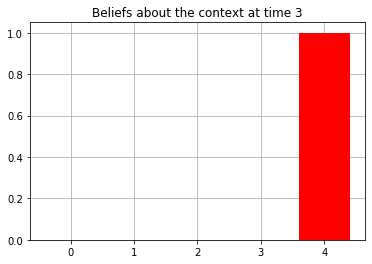

Action at time 3: noAction_agt1
Outcome at time 3: outcome_present
Obs_action_self at time 3: noPress_agt1
Obs_action_other at time 3: noPress_agt2


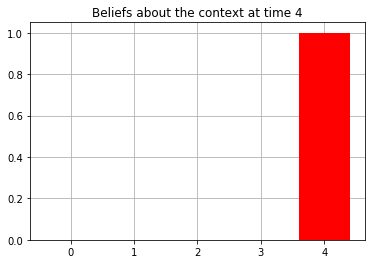

Action at time 4: noAction_agt1
Outcome at time 4: outcome_present
Obs_action_self at time 4: noPress_agt1
Obs_action_other at time 4: noPress_agt2


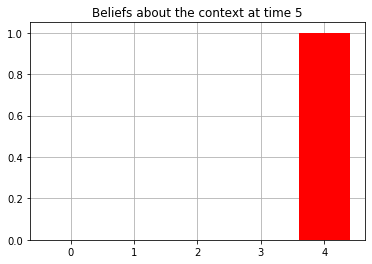

Action at time 5: noAction_agt1
Outcome at time 5: outcome_present
Obs_action_self at time 5: noPress_agt1
Obs_action_other at time 5: Press_agt2


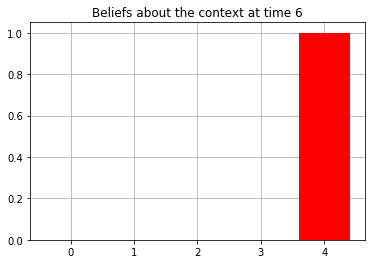

Action at time 6: noAction_agt1
Outcome at time 6: outcome_present
Obs_action_self at time 6: noPress_agt1
Obs_action_other at time 6: noPress_agt2


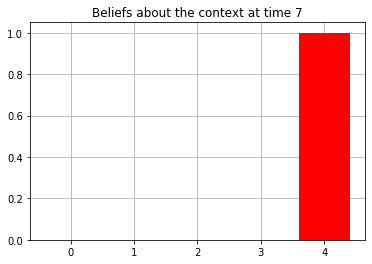

Action at time 7: noAction_agt1
Outcome at time 7: outcome_present
Obs_action_self at time 7: noPress_agt1
Obs_action_other at time 7: Press_agt2


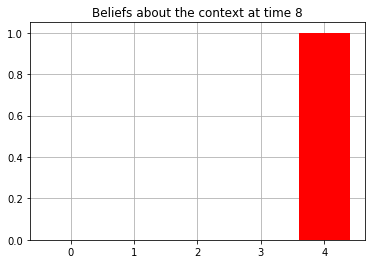

Action at time 8: noAction_agt1
Outcome at time 8: outcome_present
Obs_action_self at time 8: noPress_agt1
Obs_action_other at time 8: Press_agt2


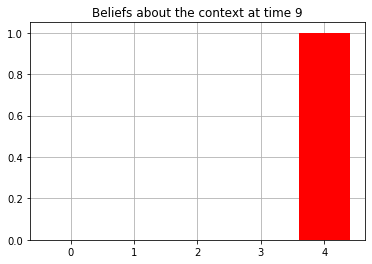

Action at time 9: noAction_agt1
Outcome at time 9: outcome_present
Obs_action_self at time 9: noPress_agt1
Obs_action_other at time 9: Press_agt2


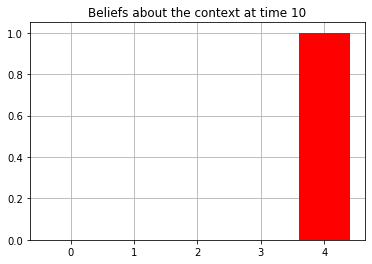

Action at time 10: noAction_agt1
Outcome at time 10: outcome_present
Obs_action_self at time 10: noPress_agt1
Obs_action_other at time 10: Press_agt2


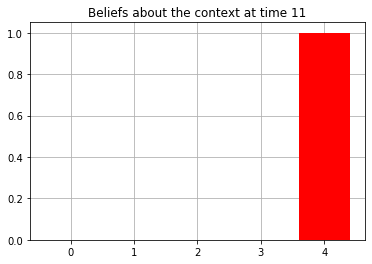

Action at time 11: noAction_agt1
Outcome at time 11: outcome_present
Obs_action_self at time 11: noPress_agt1
Obs_action_other at time 11: noPress_agt2


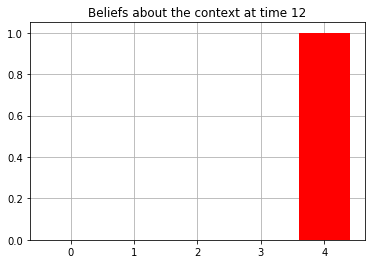

Action at time 12: noAction_agt1
Outcome at time 12: outcome_present
Obs_action_self at time 12: noPress_agt1
Obs_action_other at time 12: noPress_agt2


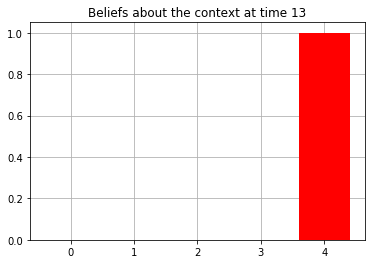

Action at time 13: noAction_agt1
Outcome at time 13: outcome_present
Obs_action_self at time 13: noPress_agt1
Obs_action_other at time 13: Press_agt2


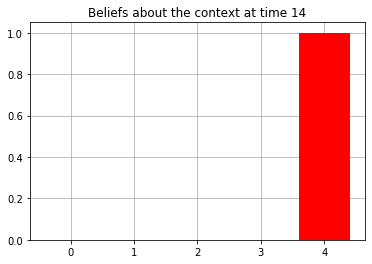

Action at time 14: noAction_agt1
Outcome at time 14: outcome_present
Obs_action_self at time 14: noPress_agt1
Obs_action_other at time 14: noPress_agt2


In [10]:
p_outcome_env = 1.0
p_action_agt2_env = 0.5

env = AgencyTask(p_action_agt2 = p_action_agt2_env, p_outcome = p_outcome_env)

T = 15

A = create_A(p_outcome = 1.0)
B = create_B(p_change = 0.0)
C = create_C(reward = 1.0, pun = 0.0, actioncost = 0.0)
D = create_D(p_context=1/float(num_states[0]))
my_agent = Agent(A=A, B=B, C=C, D=D)

choice_hist, belief_hist, context_hist = run_active_inference_loop(my_agent, env, T = T, verbose = True)

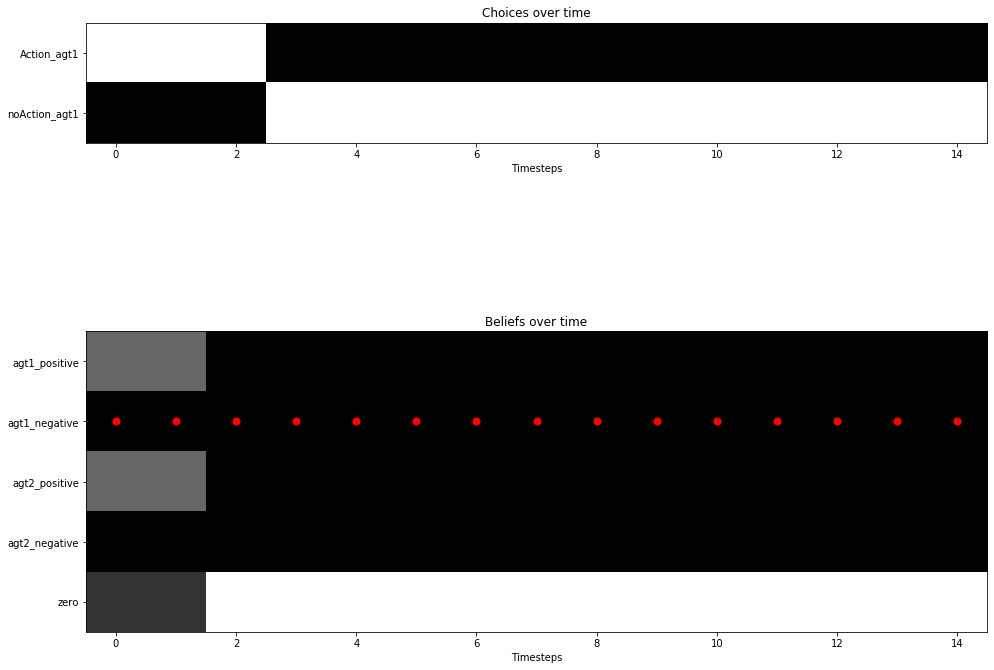

In [11]:
plot_choices_beliefs(choice_hist, belief_hist, context_hist)